# Algoritmo di Prim

L'algoritmo di Prim è uno degli algoritmi più noti che trova il minimo albero ricoprente di un grafo. 

<u>Reminder sul minimo albero ricoprente</u>

Dato un grafo $G = <N, E, \lambda >$, un albero $A = <N, E_A, \lambda_A >$ è un minimo albero ricoprente se non esiste alcun altro albero ricoprente $A'$ t.c $\text{costo}(A') > \text{costo}(A)$

Inoltre l'algoritmo di Prim è un *algoritmo goloso*. Pertando, lo possiamo caratterizzare da:
- Spazio delle possibili soluzioni: $A = <N_A, E_A, \lambda_A>$
- Soluzione iniziale: $A_0 = <\{u\}, \emptyset>, \cdots>$
- Regola di movimento: $A' \to A'' = <N' \cup \{x\}, E' \cup \{(y, x)\}, \lambda''>, \quad x\notin N'$
- Costo di una soluzione: *somma degli archi dell'albero*
- Criterio di terminazione: $N_A \equiv N$ 

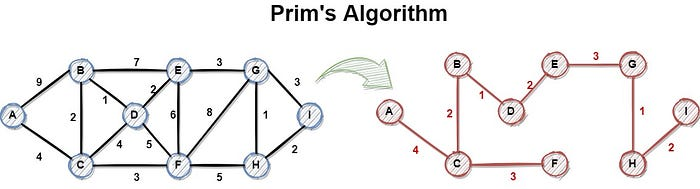

## Implementazione

Una delle possibili implementazioni consiste nel tenersi 3 array:
1. `presente_sol : bool[]` - la posizione i è a true se il nodo i è stato inserito nella soluzione
2. `pesi : int[]` - conserva l'arco di peso minimo per raggiungere il nodo i (fino a quel momento)
3. `padri : int[]` - conserva i padri relativi agli archi di peso minimo

Nell'algoritmo di Prim quindi partiamo da un nodo a caso e poi esploriamo gli adiacenti, per ognuno di essi aggiorniamo l'array dei pesi e dei padri se il peso per raggiungerlo dal nodo preso in considerazione è minore.

In [95]:
import sys
from grafi.grafinopesati import GrafoNOP, GrafoNOLAP

In [96]:
def prim( g:GrafoNOP ) -> GrafoNOP:
    # Inizializzo le strutture dati di supporto
    presente_sol : list[bool] = [False]*g.n
    pesi : list[int] = [sys.maxsize]*g.n
    padri : list[int] = [-1]*g.n
    
    ret : GrafoNOP = GrafoNOLAP(g.n) # Albero in uscita
    nodo_rif : int = 0
    presente_sol[nodo_rif] = True
    pesi[nodo_rif] = 0
    padri[nodo_rif] = 0
    while ( any(not x for x in presente_sol) ): # Finché non ho inserito tutti i nodi nella soluzione
        # Scorro gli adiacenti
        for arco in g.adiacenti(nodo_rif):
            if ( not presente_sol[arco.y] and arco.peso < pesi[arco.y] ):
                pesi[arco.y] = arco.peso
                padri[arco.y] = nodo_rif
        # Scelgo il prossimo nodo di riferimento (quello il cui costo di raggiungimento è minimo)
        min_peso = min( [pesi[i] for i in range(g.n) if presente_sol[i] == False] )
        min_nodo = -1
        for i in range(g.n):
            if presente_sol[i] == False and pesi[i] == min_peso: 
                min_nodo = i 
                break

        x, y = padri[min_nodo], min_nodo
        ret.aggiungiarco(x,y,min_peso) # aggiungo l'arco alla soluzione

        nodo_rif = y # aggiorno il nodo di riferimento
        presente_sol[nodo_rif] = True
        
    return ret

Consideriamo ora il minimo albero ricoprente del seguente grafo:
<img src="image.png" alt="alt text"
     style="display:block; margin:auto; width:300px;">

In [97]:
# Speriamo funzioni

g : GrafoNOP = GrafoNOLAP(5)
g.aggiungiarco(0,1,1)
g.aggiungiarco(0,3,1)
g.aggiungiarco(0,4,5)
g.aggiungiarco(1,2,4)
g.aggiungiarco(1,3,2)
g.aggiungiarco(2,3,1)
g.aggiungiarco(3,4,3)

min_albero_ricoprente = prim(g)
min_albero_ricoprente.stampa()

(0, 1, 1)
(0, 3, 1)
(1, 0, 1)
(2, 3, 1)
(3, 0, 1)
(3, 2, 1)
(3, 4, 3)
(4, 3, 3)


**Considerazioni**

In questa implementazione a ogni passo / *per ogni nodo* scorro gli adiacenti del nodo di riferimento e aggiorno i 3 vettori (al massimo 3 aggiornamenti per ogni adiacente). Inoltre *per ogni nodo* mi procuro il prossimo nodo da restituire con una ricerca del minimo.

Il costo è pertando $O(n^2)$ indipendentemente dal tipo di implementazione del grafo (se LA o MA).

Per ridurre il costo posso pensare di agire sulla ricerca del minimo mantenendomi una struttura dati heap (modificabile) in cui mantengo delle coppie <nodo x, peso dell'arco minimo per raggiungere x>. In questo modo *per ogni arco faccio l'inserimento o l'update* della struttura dati heap. Questo riduce il costo a $O(m \cdot \log(n))$

In [98]:
from heap.heap import Heap
from heap.heapmodificabile import HeapModificabile
from grafi.algosugrafipesati import Pair

In [99]:
def prim_migliorato( g:GrafoNOP ) -> GrafoNOP:
    # Inizializzo le strutture dati di supporto
    presente_sol : list[bool] = [False]*g.n
    pesi : list[int] = [sys.maxsize]*g.n
    padri : list[int] = [-1]*g.n
    heap : HeapModificabile[Pair] = HeapModificabile(g.n)
    
    ret : GrafoNOP = GrafoNOLAP(g.n) # Albero in uscita
    nodo_rif : int = 0
    presente_sol[nodo_rif] = True
    pesi[nodo_rif] = 0
    padri[nodo_rif] = 0
    
    # Inizializzo l'heap con gli adiacenti di 0
    for arco in g.adiacenti(nodo_rif):
        heap.ins(Pair(arco.y, arco.peso))
        pesi[arco.y] = arco.peso
        padri[arco.y] = 0 # nodo_rif

    while ( not heap.evuoto() ): # Finché non ho inserito tutti i nodi nella soluzione
        nodo : Pair = heap.out() # Pair ( nodo, arco min per raggiungerlo )
        nodo_rif = nodo.x 

        x, y = padri[nodo_rif], nodo_rif
        ret.aggiungiarco(x,y,nodo.p) # aggiungo l'arco alla soluzione
        presente_sol[nodo_rif] = True

        # Scorro gli adiacenti
        for arco in g.adiacenti(nodo_rif):
            if ( not presente_sol[arco.y] ):
                a = Pair(arco.y, arco.peso)
                if ( padri[arco.y] == -1 ):
                    heap.ins(a)
                    pesi[arco.y] = arco.peso
                    padri[arco.y] = nodo_rif
                elif ( arco.peso < pesi[arco.y] ):
                    heap.update(a)
                    pesi[arco.y] = arco.peso
                    padri[arco.y] = nodo_rif
        
    return ret

Consideriamo ancora il minimo albero ricoprente del grafo di prima:
<img src="image.png" alt="alt text"
     style="display:block; margin:auto; width:300px;">

In [100]:
# Speriamo funzioni

g : GrafoNOP = GrafoNOLAP(5)
g.aggiungiarco(0,1,1)
g.aggiungiarco(0,3,1)
g.aggiungiarco(0,4,5)
g.aggiungiarco(1,2,4)
g.aggiungiarco(1,3,2)
g.aggiungiarco(2,3,1)
g.aggiungiarco(3,4,3)

min_albero_ricoprente = prim_migliorato(g)
min_albero_ricoprente.stampa()

(0, 1, 1)
(0, 3, 1)
(1, 0, 1)
(2, 3, 1)
(3, 0, 1)
(3, 2, 1)
(3, 4, 3)
(4, 3, 3)


Giusto per confrontare con l'esempio utilizzando in  `Dijkstra.ipynb` :

In [101]:
# Speriamo funzioni

g : GrafoNOP = GrafoNOLAP(4)
g.aggiungiarco(0,1,1)
g.aggiungiarco(0,3,2)
g.aggiungiarco(1,2,1)
g.aggiungiarco(2,3,1)

min_albero_ricoprente = prim(g)
min_albero_ricoprente.stampa()

(0, 1, 1)
(1, 0, 1)
(1, 2, 1)
(2, 1, 1)
(2, 3, 1)
(3, 2, 1)
